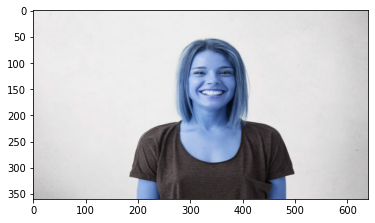

In [54]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

# 이미지 처리를 위해 opencv와 노트북에 이미지 출력을 위한 matplotlib을 읽어옴
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

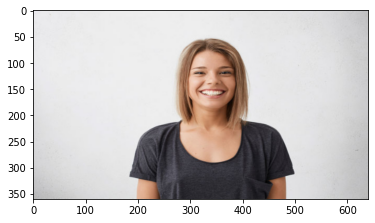

In [55]:
# opencv의 BGR설정
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [56]:
# face detection을 위한 hog detector을 선언
# cv2.cvtColor(원본이미지, 색상변환코드) -> 이미지의 색상 공간을 변경
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

In [57]:
#detector을 이용해 얼굴의 bounding box추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

In [58]:
# detector를 이용해 찾은 얼굴 영역의 bounding box를 띄우기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()  #dlib detector는 dlib.rectangles타입의 객체를 반환

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)


In [59]:
# 저장한 랜드마크 모델을 불러옴
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [60]:
# landmakr_predictor을 통해 RGB 이미지와 dlib.rectangle을 입력받아 dlib.full_object_detection을 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

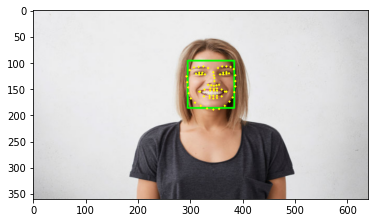

In [61]:
# 랜드마크를 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [62]:
# 스티커 적용하기 위한 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(346, 135)
(x,y) : (346,135)
(w,h) : (90,90)


In [63]:
# 스티커를 resize함
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)    # cv2.imread("경로", mode)를 이용하여 이미지를 불러와 변수에 저장.
img_sticker = cv2.resize(img_sticker, (w, h))
print("이미지의 크기" , img_sticker.shape)

이미지의 크기 (90, 90, 3)


In [64]:
# 원본 이미지에 스티커 이미지 추가 위해서 x,y 좌표 조정
refined_x = x - w // 2  # left
refined_y = y - h // 2    # top
print ('refinded (x,y) : (%d,%d)'%(refined_x, refined_y))

refinded (x,y) : (301,90)



- 원본 이미지에 스티커를 적용  & 출력
- 검정색 출력 위해 img_sticker == 1 을 지정 ?? 다른 숫자로 바꿔야 할듯 -> 255로 하면 검정색만 나옴
- np.where(조건식, x, y) -> 조건식과 일치하는 경우에는 x값을 반환, 일치하지 않은 경우에는 y값을 반환
즉 조건식과 일치하는 경우에는(img_sticker가 255인 영역은) sticker의 픽셀을 출력하고
그렇지 않은 곳은 원본 이미지의 픽셀을 출력



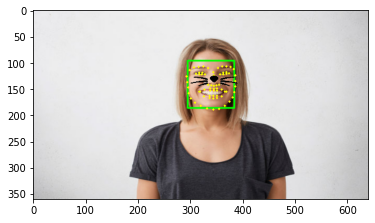

In [65]:
# 원본 이미지에 스티커를 적용  & 출력
# 검정색 출력 위해 img_sticker == 1 을 지정 ?? 다른 숫자로 바꿔야 할듯
# np.where(조건식, x, y) -> 조건식과 일치하는 경우에는 x값을 반환, 일치하지 않은 경우에는 y값을 반환
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y : refined_y+img_sticker.shape[0], refined_x : refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

'''
unit8 : 양수만 표현 가능 0~255
pd.astype(dtype) # 모든 열의 데이터 타입을 변경
'''

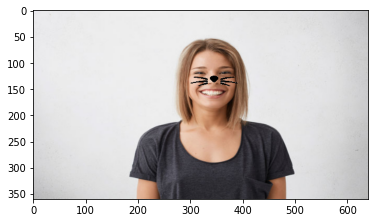

In [66]:
# bounding box와 landmark 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

다양한 이미지 적용했을 때의 문제점을 체계적으로 분석
ex) 얼굴각도, 이미지 밝기, 촬영각도 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석

참고 : https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c



face landmark estimation이라는 알고리즘을 사용해보자,,
